# Using GXBeam with DifferentialEquations.jl

While the capabilities provided by GXBeam are probably sufficient for most users,
advanced users may wish to make use of some of the features of the
[`DifferentialEquations`](https://github.com/SciML/DifferentialEquations.jl) package.
For this reason, we have created an interface in GXBeam to allow users to model the
differential algebraic equations encountered in GXBeam using DifferentialEquations.

## Example Usage

For this example we demonstrate how to solve the wind turbine [Time-Domain Simulation of
a Wind Turbine Blade](@ref wind-turbine-blade) problem using DifferentialEquations.

We start by setting up the problem as if we were solving the problem using GXBeam's
internal solver.

In [1]:
using GXBeam, LinearAlgebra

L = 60 # m

# create points
nelem = 10
x = range(0, L, length=nelem+1)
y = zero(x)
z = zero(x)
points = [[x[i],y[i],z[i]] for i = 1:length(x)]

# index of endpoints of each beam element
start = 1:nelem
stop = 2:nelem+1

# stiffness matrix for each beam element
stiffness = fill(
    [2.389e9  1.524e6  6.734e6 -3.382e7 -2.627e7 -4.736e8
     1.524e6  4.334e8 -3.741e6 -2.935e5  1.527e7  3.835e5
     6.734e6 -3.741e6  2.743e7 -4.592e5 -6.869e5 -4.742e6
    -3.382e7 -2.935e5 -4.592e5  2.167e7 -6.279e5  1.430e6
    -2.627e7  1.527e7 -6.869e5 -6.279e5  1.970e7  1.209e7
    -4.736e8  3.835e5 -4.742e6  1.430e6  1.209e7  4.406e8],
    nelem)

# mass matrix for each beam element
mass = fill(
    [258.053      0.0        0.0      0.0      7.07839  -71.6871
       0.0      258.053      0.0     -7.07839  0.0        0.0
       0.0        0.0      258.053   71.6871   0.0        0.0
       0.0       -7.07839   71.6871  48.59     0.0        0.0
       7.07839    0.0        0.0      0.0      2.172      0.0
     -71.6871     0.0        0.0      0.0      0.0       46.418],
     nelem)

# create assembly of interconnected nonlinear beams
assembly = Assembly(points, start, stop; stiffness=stiffness, mass=mass)

# prescribed conditions
prescribed_conditions = (t) -> begin
    Dict(
        # fixed left side
        1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0, theta_z=0),
        # force on right side
        nelem+1 => PrescribedConditions(Fz = 1e5*sin(20*t))
    )
end

nothing #hide

At this point if we wanted to use GXBeam's internal solver, we would choose a time
discretization and call the `time_domain_analysis` function.

In [2]:
# simulation time
t = 0:0.001:2.0

system, gxbeam_history, converged = time_domain_analysis(assembly, t;
    prescribed_conditions = prescribed_conditions,
    structural_damping = false)

nothing #hide

To instead use the capabilities of the DifferentialEquations package, we first initialize
our system using the `initial_condition_analysis` function and then construct and solve
a `DAEProblem`.

In [3]:
using DifferentialEquations

# define simulation time
tspan = (0.0, 2.0)

# run initial condition analysis to get consistent set of initial conditions
dae_system, converged = initial_condition_analysis(assembly, tspan[1];
    prescribed_conditions = prescribed_conditions,
    structural_damping = false)

# construct an ODEProblem (with a constant mass matrix)
dae_prob = DAEProblem(dae_system, assembly, tspan;
    prescribed_conditions = prescribed_conditions,
    structural_damping = false)

# solve the problem
dae_sol = solve(dae_prob, DABDF2())

nothing #hide

Alternatively, we can use a mass matrix formulation of our differential algebraic equations.

In [4]:
# run initial condition analysis to get consistent set of initial conditions
ode_system, converged = initial_condition_analysis(assembly, tspan[1];
    prescribed_conditions = prescribed_conditions,
    constant_mass_matrix = true,
    structural_damping = false)

# construct an ODEProblem (with a constant mass matrix)
ode_prob = ODEProblem(ode_system, assembly, tspan;
    prescribed_conditions = prescribed_conditions,
    constant_mass_matrix = true,
    structural_damping = false)

# solve the problem
ode_sol = solve(ode_prob, Rodas4())

nothing #hide

We can then extract the outputs from the solution in a easy to understand format using the
`AssemblyState` constructor.

In [5]:
ode_history = [AssemblyState(ode_sol[it], ode_system, assembly; prescribed_conditions)
    for it in eachindex(ode_sol)]

dae_history = [AssemblyState(dae_sol[it], dae_system, assembly; prescribed_conditions)
    for it in eachindex(dae_sol)]

nothing #hide

Let's now compare the solutions from GXBeam's internal solver and the
DifferentialEquations solvers.

In [6]:
using Plots
pyplot()


point = vcat(fill(nelem+1, 6), fill(1, 6))
field = [:u, :u, :u, :theta, :theta, :theta, :F, :F, :F, :M, :M, :M]
direction = [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]
ylabel = ["\$u_x\$ (\$m\$)", "\$u_y\$ (\$m\$)", "\$u_z\$ (\$m\$)",
    "Rodriguez Parameter \$\\theta_x\$ (degree)",
    "Rodriguez Parameter \$\\theta_y\$ (degree)",
    "Rodriguez Parameter \$\\theta_z\$ (degree)",
    "\$F_x\$ (\$N\$)", "\$F_y\$ (\$N\$)", "\$F_z\$ (\$N\$)",
    "\$M_x\$ (\$Nm\$)", "\$M_y\$ (\$Nm\$)", "\$M_z\$ (\$N\$)"]
ph = Vector{Any}(undef, 12)

for i = 1:12
    #md local y #hide
   ph[i] = plot(
        xlim = (0, 2.0),
        xticks = 0:0.5:2.0,
        xlabel = "Time (s)",
        ylabel = ylabel[i],
        grid = false,
        overwrite_figure=false
        )
    y_gxbeam = [getproperty(state.points[point[i]], field[i])[direction[i]]
        for state in gxbeam_history]

    y_ode = [getproperty(state.points[point[i]], field[i])[direction[i]]
        for state in ode_history]

    y_dae = [getproperty(state.points[point[i]], field[i])[direction[i]]
        for state in dae_history]

    if field[i] == :theta
        # convert to Rodriguez parameter
        @. y_gxbeam = 4*atan(y_gxbeam/4)
        @. y_ode = 4*atan(y_ode/4)
        @. y_dae = 4*atan(y_dae/4)
        # convert to degrees
        @. y_gxbeam = rad2deg(y_gxbeam)
        @. y_ode = rad2deg(y_ode)
        @. y_dae = rad2deg(y_dae)
    end

    if field[i] == :F || field[i] == :M
        y_gxbeam = -y_gxbeam
        y_ode = -y_ode
        y_dae = -y_dae
    end

    plot!(t, y_gxbeam, label="GXBeam")
    plot!(ode_sol.t, y_ode, label="ODEProblem")
    plot!(dae_sol.t, y_dae, label="DAEProblem")
end

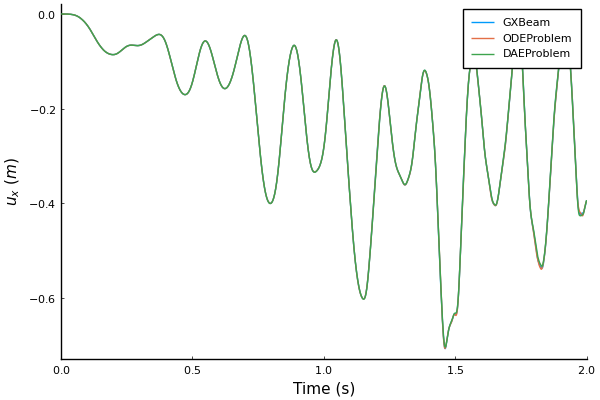

In [7]:
ph[1]

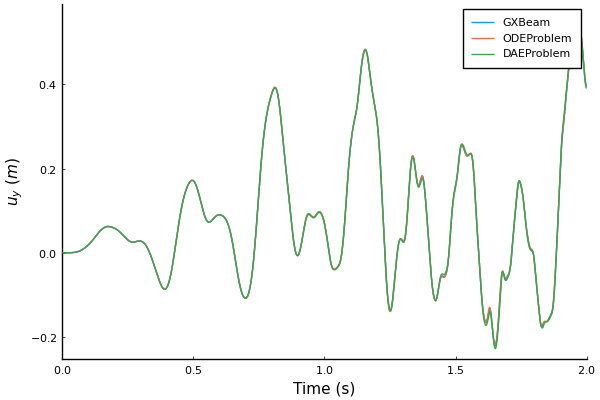

In [8]:
ph[2]

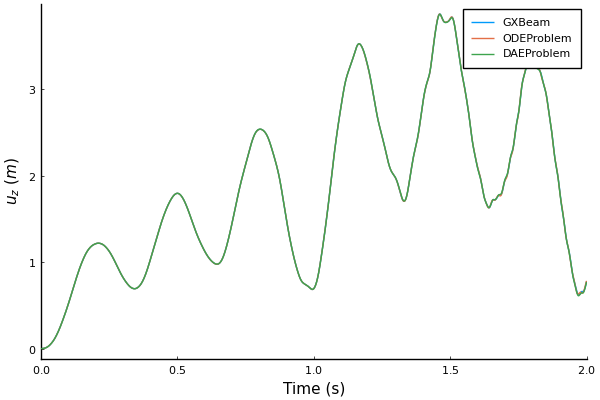

In [9]:
ph[3]

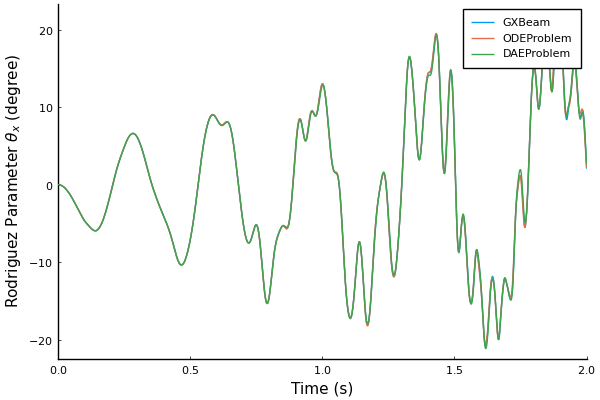

In [10]:
ph[4]

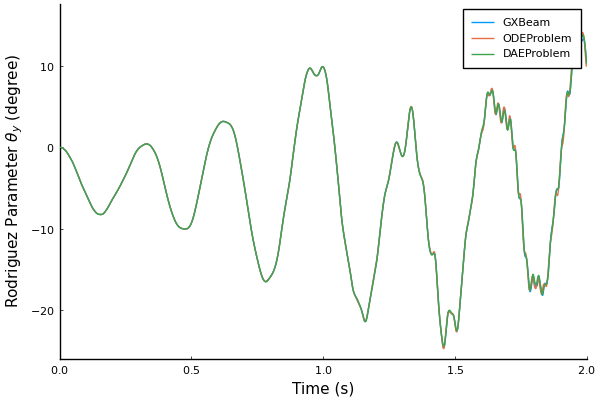

In [11]:
ph[5]

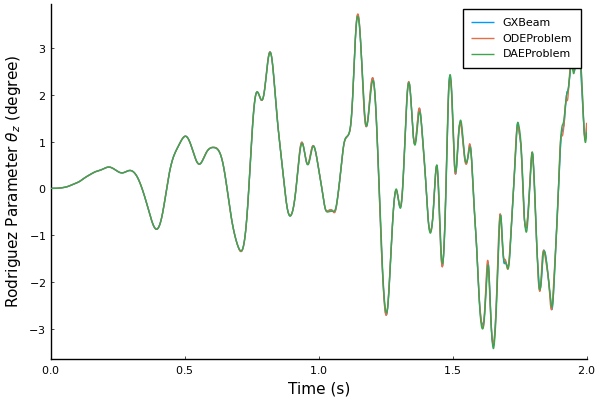

In [12]:
ph[6]

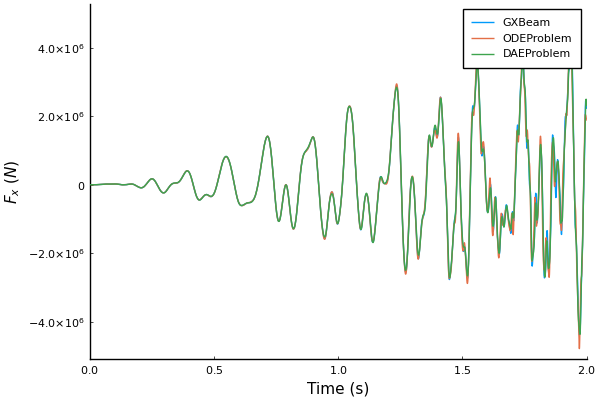

In [13]:
ph[7]

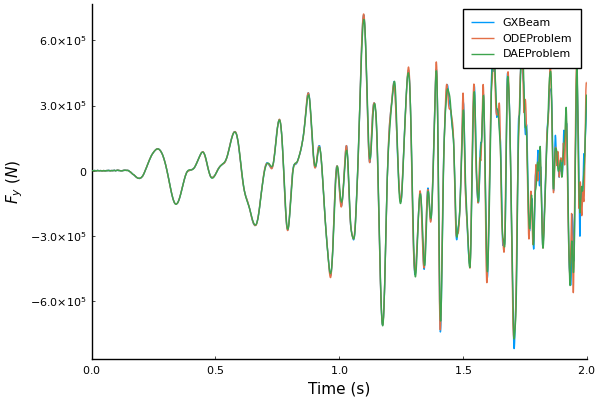

In [14]:
ph[8]

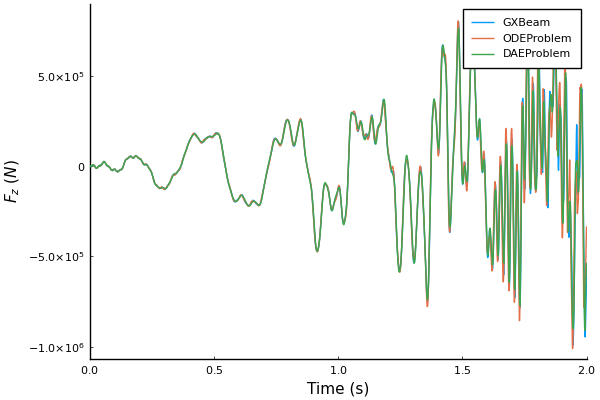

In [15]:
ph[9]

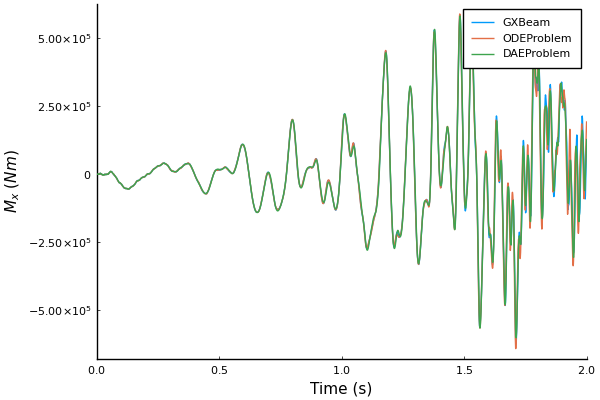

In [16]:
ph[10]

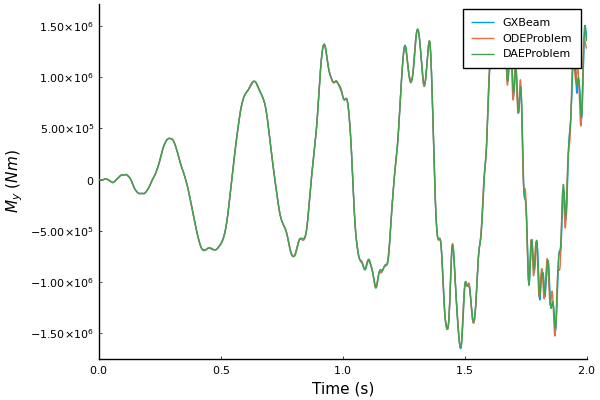

In [17]:
ph[11]

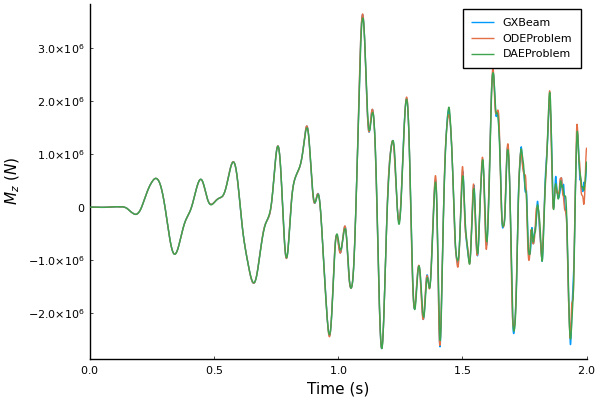

In [18]:
ph[12]

As can be seen, the solutions provided by GXBeam and DifferentialEquations track closely
with each other.

In [19]:
root_chord = 1.9000
tip_chord =  0.4540
airfoil = [ # MH-104
    1.00000000  0.00000000;
    0.99619582  0.00017047;
    0.98515158  0.00100213;
    0.96764209  0.00285474;
    0.94421447  0.00556001;
    0.91510964  0.00906779;
    0.88074158  0.01357364;
    0.84177999  0.01916802;
    0.79894110  0.02580144;
    0.75297076  0.03334313;
    0.70461763  0.04158593;
    0.65461515  0.05026338;
    0.60366461  0.05906756;
    0.55242353  0.06766426;
    0.50149950  0.07571157;
    0.45144530  0.08287416;
    0.40276150  0.08882939;
    0.35589801  0.09329359;
    0.31131449  0.09592864;
    0.26917194  0.09626763;
    0.22927064  0.09424396;
    0.19167283  0.09023579;
    0.15672257  0.08451656;
    0.12469599  0.07727756;
    0.09585870  0.06875796;
    0.07046974  0.05918984;
    0.04874337  0.04880096;
    0.03081405  0.03786904;
    0.01681379  0.02676332;
    0.00687971  0.01592385;
    0.00143518  0.00647946;
    0.00053606  0.00370956;
    0.00006572  0.00112514;
    0.00001249 -0.00046881;
    0.00023032 -0.00191488;
    0.00079945 -0.00329201;
    0.00170287 -0.00470585;
    0.00354717 -0.00688469;
    0.00592084 -0.00912202;
    0.01810144 -0.01720842;
    0.03471169 -0.02488211;
    0.05589286 -0.03226730;
    0.08132751 -0.03908459;
    0.11073805 -0.04503763;
    0.14391397 -0.04986836;
    0.18067874 -0.05338180;
    0.22089879 -0.05551392;
    0.26433734 -0.05636585;
    0.31062190 -0.05605816;
    0.35933893 -0.05472399;
    0.40999990 -0.05254383;
    0.46204424 -0.04969990;
    0.51483073 -0.04637175;
    0.56767889 -0.04264894;
    0.61998250 -0.03859653;
    0.67114514 -0.03433153;
    0.72054815 -0.02996944;
    0.76758733 -0.02560890;
    0.81168064 -0.02134397;
    0.85227225 -0.01726049;
    0.88883823 -0.01343567;
    0.92088961 -0.00993849;
    0.94797259 -0.00679919;
    0.96977487 -0.00402321;
    0.98607009 -0.00180118;
    0.99640466 -0.00044469;
    1.00000000  0.00000000;
]

sections = zeros(3, size(airfoil, 1), length(points))
for ip = 1:length(points)
    chord = root_chord * (1 - x[ip]/L) + tip_chord * x[ip]/L
    sections[1, :, ip] .= 0
    sections[2, :, ip] .= chord .* (airfoil[:,1] .- 0.5)
    sections[3, :, ip] .= chord .* airfoil[:,2]
end

mkpath("dynamic-wind-turbine")
write_vtk("dynamic-wind-turbine/dynamic-wind-turbine", assembly, gxbeam_history, t; sections = sections)

![](../assets/wind-turbine-blade-simulation.gif)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*